In [11]:
from prototree.prototree import ProtoTree
from prototree.branch import Branch
from prototree.leaf import Leaf
from prototree.node import Node
import torch

import argparse
import torch.nn as nn
from torchvision.models import resnet50

import torchvision.transforms as transforms
import torchvision

import torch.nn as nn
import torch.optim as optim

# # Define the number of classes
# num_classes = 15  

# # Define the feature extraction network
# feature_net = resnet50(pretrained=True)

# # Define the arguments
# args = argparse.Namespace(depth=5, num_features=512, W1=10, H1=10, log_probabilities=None, disable_derivative_free_leaf_optim=False, kontschieder_normalization=False, kontschieder_train=False)
# # Initialize the ProtoTree
# model = ProtoTree(num_classes, feature_net, args)

In [2]:
# Load the model state dictionary
# model_state_dict = torch.load('/home/dhaval/prototree/runs/run_prototree/checkpoints/best_test_model/model_state.pth')  
# model.load_state_dict(model_state_dict)

# Load the optimizer state dictionary
# optimizer_state_dict = torch.load('/home/dhaval/prototree/runs/run_prototree/checkpoints/best_test_model/optimizer_state.pth')  
# optimizer.load_state_dict(optimizer_state_dict)

# Switch to evaluation mode
# model.eval()

In [12]:
def get_nih(
    augment: bool, train_dir: str, project_dir: str, test_dir: str, img_size=224
):
    shape = (3, img_size, img_size)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    normalize = transforms.Normalize(mean=mean, std=std)
    transform_no_augment = transforms.Compose(
        [transforms.Resize(size=(img_size, img_size)), transforms.ToTensor(), normalize]
    )
    if augment:
        transform = transforms.Compose(
            [
                transforms.Resize(
                    size=(img_size + 32, img_size + 32)
                ),  # resize to 256x256
                transforms.RandomOrder(
                    [
                        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                        transforms.ColorJitter(brightness=0.25, contrast=0.25),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomAffine(
                            15, translate=(0.1, 0.1), scale=(0.9, 1.1)
                        ),
                    ]
                ),
                transforms.RandomCrop(size=(img_size, img_size)),  # crop to 224x224
                transforms.ToTensor(),
                normalize,
            ]
        )
    else:
        transform = transform_no_augment
    trainset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
    projectset = torchvision.datasets.ImageFolder(
        project_dir, transform=transform_no_augment
    )
    testset = torchvision.datasets.ImageFolder(test_dir, transform=transform_no_augment)
    classes = trainset.classes
    return trainset, projectset, testset, classes, shape



In [15]:
if torch.cuda.is_available():
        # device = torch.device('cuda')
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = torch.device('cpu')


trainloader, projectloader, testloader, classes, num_channels = get_dataloaders(
        batch_size=32
    )

Num classes (k) =  3


In [16]:
tree = torch.load('runs/run_prototree/checkpoints/best_test_model/model.pth', map_location=device)

In [17]:
img_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

normalize = transforms.Normalize(mean=mean, std=std)

transform_no_augment = transforms.Compose(
        [transforms.Resize(size=(img_size, img_size)), transforms.ToTensor(), normalize]
    )

In [18]:
torch.cuda.empty_cache()

# test_dir = "./data/NIH_CHEST_XRAYS/dataset/test_full"

# testset = torchvision.datasets.ImageFolder(test_dir, transform=transform_no_augment)
# testloader = torch.utils.data.DataLoader(
#         testset, batch_size=16, shuffle=False, pin_memory=device
#     )

current = []
predictions = []
tree.eval()
for i, (xs, ys) in enumerate(testloader):
    xs, ys = xs.to(device), ys.to(device)

    out, test_info = tree.forward(xs, 'distributed')
    ys_pred = torch.argmax(out, dim=1)
    predictions.append(ys_pred)
    current.append(ys)


In [19]:
import numpy as np

concatenated_pred = torch.cat(predictions)
concatenated_current = torch.cat(current)

con_final_pred = concatenated_pred.cpu()
con_final_current = concatenated_current.cpu()

np_pred = con_final_pred.numpy()
np_current = con_final_current.numpy()

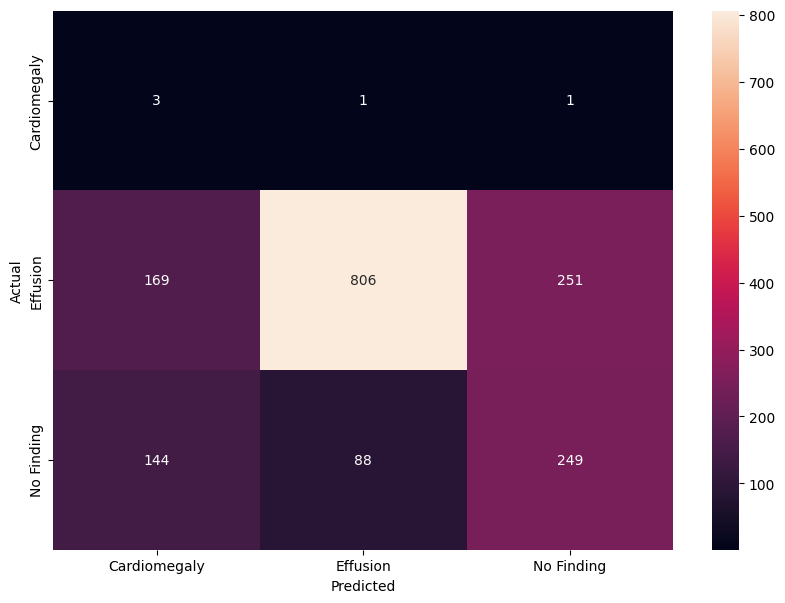

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

classes = testset.classes

cm = confusion_matrix(np_pred, np_current)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(np_pred, np_current, target_names=classes)
print(report)

              precision    recall  f1-score   support

Cardiomegaly       0.01      0.60      0.02         5
    Effusion       0.90      0.66      0.76      1226
  No Finding       0.50      0.52      0.51       481

    accuracy                           0.62      1712
   macro avg       0.47      0.59      0.43      1712
weighted avg       0.78      0.62      0.69      1712

